### VGG16
VGG16 is a type of neural network which worked really well on ImageNet dataset which has 14 million images with 1000 class labels in 2014. It acheived 92.7% top-5 test accuarcy on ImageNet. Before that, we had Alexnet, 


It is built using 16 layers out of which 13 are convolution layers and 3 are fully connected layers. There are stacked convlutions followed by MaxPooling. Architecture looks something like this:

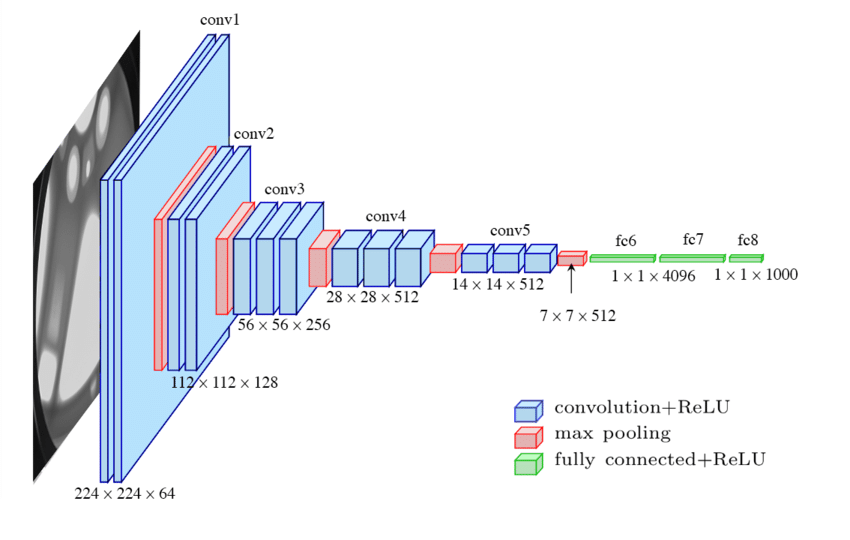

Another way of looking into it:
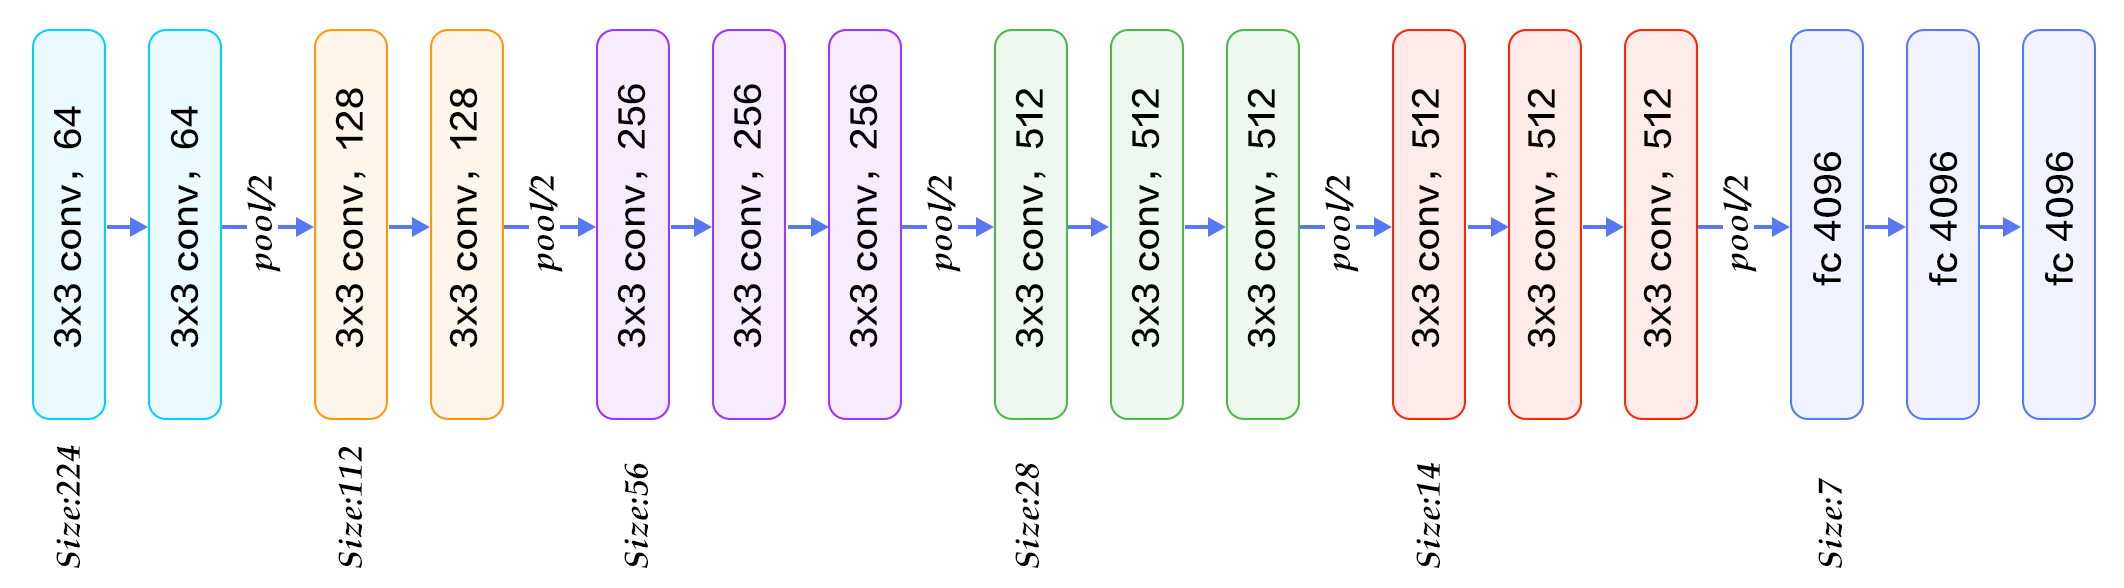

VGG16 uses colored images with shape (224, 224) dimensions. We will use trained VGG16 modle weights with some tuning to use th efeatures which it learnt from ImageNet dataset. This is also called Transfer Learning.

In [ ]:
# Importing the libraries 

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, GlobalMaxPooling2D, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import layers

from sklearn.model_selection import train_test_split


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!rm -rf "./train"
!unzip "/kaggle/input/dogs-vs-cats/train.zip"

In [ ]:
# Preparing the data
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
# Looking at the data in dataframe
df.head()

In [ ]:
# Changin the category to strings 
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [ ]:
# Shape of data
df.shape

In [ ]:
# Distribution of count classes
sns.set(style="white")
sns.countplot(df["category"])

In [ ]:
sample = np.random.choice(filenames)
image = load_img("./train/" + sample)
# Each image is of different shapes and has 3 channel for RGB
plt.imshow(image)
plt.show()

In [ ]:
# Splitting the data
train_df, test_df = train_test_split(df, test_size=.2, stratify=df["category"])
train_df = train_df.reset_index()
test_df = test_df.reset_index()

Since VGG16 is a kind of CNN, we can't have variable size of input data. Images in our dataset have different shapes, so we need to fix their size. Also, we need to fix it to (224, 224) according to VGG16 architecture. 

To remove this problem, we will use ImageDataGenerator from keras, which will augment our data to make our model robust and also will fix the dimensions to the desired ones.

In [ ]:
aug_data = ImageDataGenerator(
    rotation_range = 15, 
    shear_range = .2, 
    zoom_range = .2, 
    horizontal_flip = True, 
    vertical_flip = True, 
    width_shift_range = 0.15, 
    height_shift_range = .15, 
    fill_mode = "nearest"
)

In [ ]:
input_shape = (224, 224)
batch_size = 32

train_generator = aug_data.flow_from_dataframe(
    dataframe=train_df, 
    directory="./train/", 
    x_col = "filename",
    y_col="category", 
    class_mode = "categorical", 
    target_size = input_shape, 
    batch_size = batch_size
    )

In [ ]:
test_generator = aug_data.flow_from_dataframe(
    dataframe=test_df, 
    directory="./train/", 
    x_col = "filename",
    y_col="category", 
    class_mode = "categorical", 
    target_size = input_shape, 
    batch_size = batch_size
    )

In [ ]:
# Load the VGG16 model
# include_top = False means we don't want to take last 3 fully connected layers of VGG16 and we want weights trained on ImageNet data.
pre_trained_model = VGG16(include_top=False, weights="imagenet")

In [ ]:
pre_trained_model.summary()

As we can see, there are convolution layers followed by poling layers, we have removed FC layers. 

In this model also, we will fix the weights of initial layers and will train the last block of 3 convolution layer and 1 pooling layer.

In [ ]:
# We will fix the initial layers and only train the last stacked set of convolution layer
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
    
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

In [ ]:
# Take the output of last pooling layer
last_pooling_layer = pre_trained_model.get_layer("block5_pool")
last_output = last_pooling_layer.output

In [ ]:
# Flatten the output layer which has 512 units
x = GlobalMaxPooling2D()(last_output)

# After this add a fully connected layer with 512 units 
x = Dense(units=512, activation="relu")(x)

# Add a dropout 
x = Dropout(rate=.25)(x)

# Add a final layer for classification 
x = layers.Dense(units=2, activation="softmax")(x)

# Combine the model with our layers
model = Model(inputs=pre_trained_model.input, outputs=x)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 10
train_size = train_df.shape[0]

In [ ]:
hist = model.fit_generator(generator = train_generator, epochs = epochs, validation_data = test_generator, verbose=1, 
                           steps_per_epoch = np.ceil(train_size/batch_size))

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()